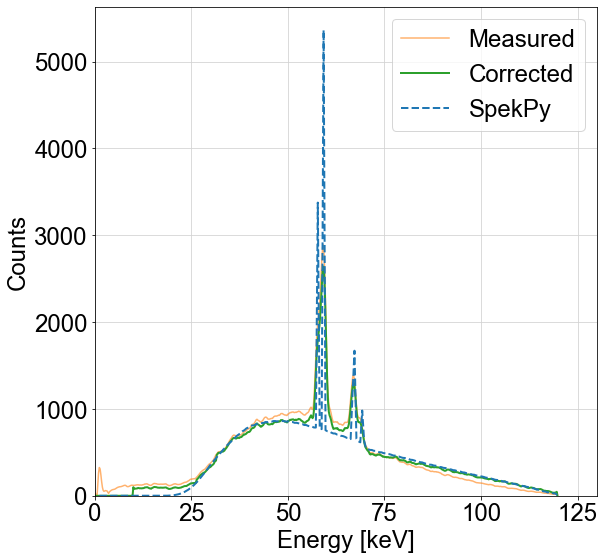

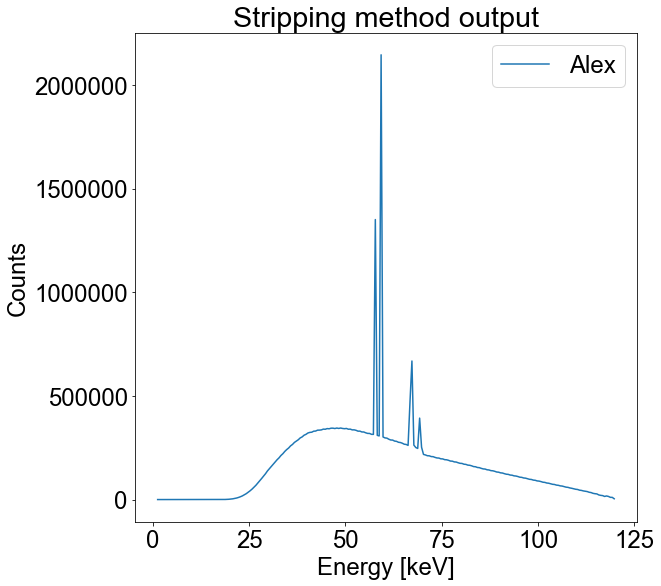

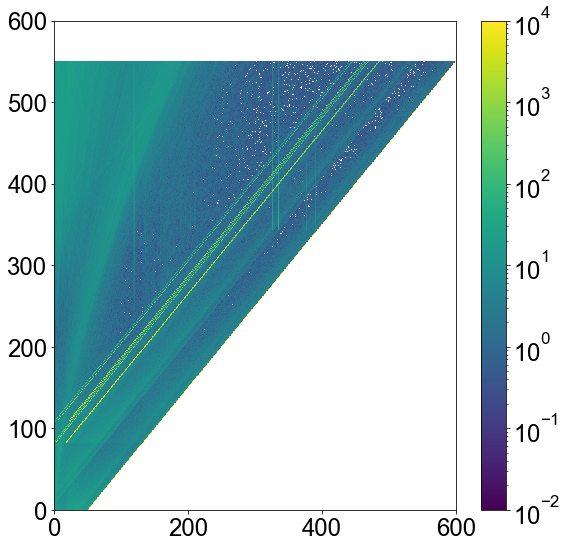

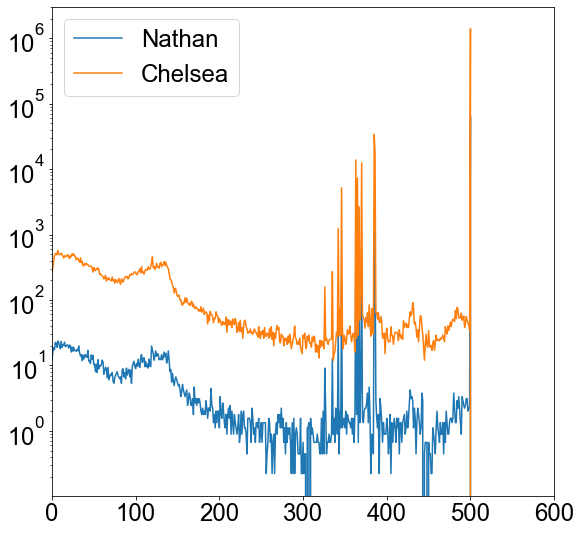

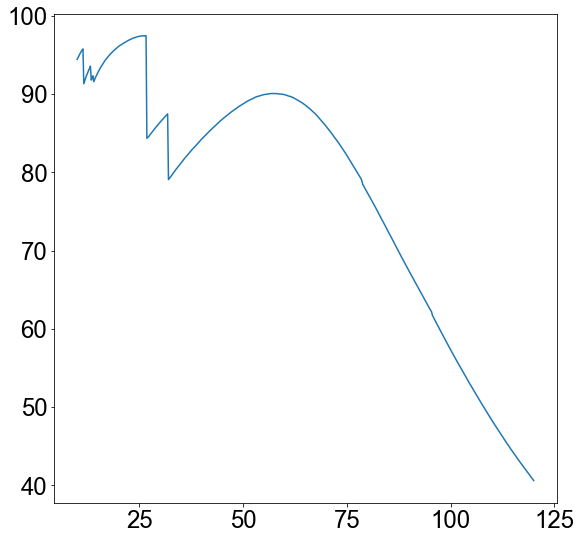

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm
from scipy.signal import savgol_filter
import matplotlib


font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)
'''
Python 2.7 (sorry)
Code for the stripping method
written by Chelsea Dunning (May 11, 2021)

To run this code, you will need the following:
 - Full Energy Absorption Efficiency (FEAE) curve for the detector type
    (ie. 100 120-keV x-rays incident on detector, how many of those x-rays were registered as 120 keV?)
 - Response functions of the detector to monoenergetic x-rays in increments of energy
    (ie. the detected energy spectrum in the detector from 5 keV, 6 keV, 7 keV, ..., 119 keV, 120 keV monoenergetic x-rays)

Lucky for you, I have generated a FEAE curve and the response functions of 25 mm^2 CdTe for you.
'''
def main():
    '''
    This is the main method that you will run
    :return: void
    '''
    #************************************ENTER STUFF BELOW*************************************************************

    #first, specify where the energy deposition histogram file is. This is an example, so the data here is Monte-Carlo
    #  generated (and in XML format, the helper function below puts it in a NumPy array). You will need to make a new helper
    #  function if you are reading in .mca format that's output from the real detector.
    data_directory = "Desktop/topas_sim_files/"
    raw_data_file = 'Desktop/CT imaging/30-6-2021/angle_120_acq_70.mca'

    # next, specific the directory of the response functions, their file name convention, and the energy range.
    dir_response_fn = data_directory + "response_functions/"
    filename_1 = "responsefunction_" #filename in two parts because that's where energy inserted
    filename_2 = "keV3x3.npy" #if you name it better, this could just be ".npy"
    min_energy = 10.0 # keV
    max_energy = 120 # keV
    energy_bin_width = 0.2 #keV, this is what I went with
    num_primaries = 5e5  # these were the number of primaries used to generate the response functions

    #then specify the directory and file name of the FEAE curve that I've provided.
    feae_file = data_directory + "abseff3x3.npy"

    #*****************************THAT'S IT! below is where the magic happens******************************************

    #Let's generate a singleton of all the response functions for easy access. this will speed up the code, promise.
    MASTER_RESPONSE = generateResponseFunctionSingleton(dir_response_fn, filename_1, filename_2, min_energy, max_energy,
                                                        energy_bin_width)

    # with XFCT data, below is where you'd loop over multiple detectors and multiple position/angles of pencil beam
    #  acquisition
    
    old_x=np.linspace(0,150.8073,1024)
    new_x=np.arange(0,120,0.2)
    counts = np.genfromtxt("Desktop/CT imaging/30-6-2021/airscan.mca", skip_header=16,skip_footer=71)
    new_counts=np.interp(new_x,old_x,counts)

    #read in the example detector energy deposition histogram data
    #energy, raw_spectrum = readXMLhistogram(raw_data_file, max_energy, energy_bin_width)

    #now strip the spectrum!
    new_counts = savgol_filter(new_counts, 31, 11)
    stripped_spectrum = stripEnergySpectrum(new_counts, MASTER_RESPONSE, min_energy, max_energy, energy_bin_width,
                                            feae_file, num_primaries)


    #let's plot raw vs. stripped spectrum
    figure(1,figsize=(9,9))
    new_x=new_x
    #plt.plot(old_x, counts, label='Original')
    #plt.bar(energy, raw_spectrum, width=energy_bin_width, color="blue")
    #plt.bar(energy, stripped_spectrum, width=energy_bin_width, color="magenta")
    alex=np.load('Desktop/CT imaging/120kV_7mmAl_Alex.npy')
    alexGd= np.load('Desktop/CT imaging/120kV_7mmAl_93.7mmHDPE_6.3mmGd0.05.npy')
    alex_water=np.load('Desktop/CT imaging/120kV_7mmAl_100mmHDPE.npy')
    plt.plot(new_x, new_counts,label='Measured',alpha=0.6,c='C1')
    plt.plot(new_x, stripped_spectrum,label='Corrected',lw=2,c='C2')
#     plt.plot(alex_water[0],alex_water[1]*np.pi*0.1**2/300,label='SpekPy',lw=2,ls='--',c='C0') #HDPE simulation
    plt.plot(alex[0],alex[1]*np.pi*0.1**2/400,label='SpekPy',lw=2,ls='--',c='C0') #air simulation
    #plt.plot(alexGd[0],alexGd[1]*np.pi*0.1**2/275,label='SpekPy',lw=2,ls='--',c='C0') #Gd simulation
    plt.xlim([0,130])
    plt.ylim(0,)
    plt.xlabel("Energy [keV]")
    plt.ylabel("Counts")
    plt.grid(c='lightgray')
    plt.legend()
    
    figure(2,figsize=(9,9))
    plt.plot(alex[0],alex[1]*np.pi*0.1**2,label='Alex')
    plt.xlabel("Energy [keV]")
    plt.ylabel("Counts")
    plt.title("Stripping method output")
    plt.legend()
    figure(3,figsize=(9,9))
    mr=[]
    for i in np.arange(50,600):
        mr.append(MASTER_RESPONSE[i])

    plt.imshow(mr,aspect='auto',norm=LogNorm(vmin=0.01, vmax=10000))
    plt.colorbar()
    plt.xlim([0,600])
    plt.ylim([0,600])
    figure(4,figsize=(9,9))
    plt.plot(np.arange(0,len(MASTER_RESPONSE[500])),MASTER_RESPONSE[500],label='Nathan')
    chelsea=np.load('Desktop/MASTER_RESPONSE[500].npy')
    plt.plot(np.arange(0,len(chelsea)),chelsea,label='Chelsea')
    plt.plot()
    plt.xlim([0,600])
    plt.yscale('log')
    plt.legend()
    
    figure(5,figsize=(9,9))
    topas_energy, topas_abseff = np.load(feae_file)
    plt.plot(topas_energy, topas_abseff*100)

    

    
    


#*****************        HELPER FUNCTIONS      *************
def generateResponseFunctionSingleton(dir_response_fn, filename_1, filename_2, min_energy, max_energy,
                                                        energy_bin_width):
    '''
    helper function for loading all response functions right away, so only have to do this once especially if looping
    over XFCT data
    :param dir_response_fn: str
    :param filename_1: str, "responsefunction"
    :param filename_2: str, "keV5x5.npy"
    :param min_energy: float
    :param max_energy: float or int
    :param energy_bin_width: float
    :return: giant object array
    '''
    MASTER_RESPONSE = np.zeros(int(1000), dtype=object)
    for j in np.arange(min_energy, max_energy+0.2, step=energy_bin_width):
        energy, edep = np.load(dir_response_fn + filename_1 + str(round(j,1)) + filename_2)       
        MASTER_RESPONSE[int(j * 5)] = edep/4.5
    return MASTER_RESPONSE

def readXMLhistogram(filename, max_energy, bin_width):
    '''
    Reads TOPAS XML file and outputs the histogram bin number and entry in a ntuple

    :return: energy bin in keV, histogram
    '''
    def missing_elements(L, start, end):
        return sorted(set(xrange(start, end + 1)).difference(L))

    length = int(int(max_energy) / bin_width)
    energy1 = np.array([])
    energydep1 = np.array([])

    e = xml.etree.ElementTree.parse(filename)

    for btype in e.findall('./histogram1d/data1d/bin1d'):
        energy1 = np.append(energy1, float(btype.get('binNum')))
        energydep1 = np.append(energydep1, float(btype.get('entries')))

    missing_indices = missing_elements(energy1, 0, length - 1)
    for i in missing_indices:
        energy1 = np.insert(energy1, i, i)
        energydep1 = np.insert(energydep1, i, 0)
    energy = energy1 * bin_width

    energydep = energydep1

    return energy, energydep

def stripEnergySpectrum(spectrum, MASTER_RESPONSE, min_energy, max_energy, width_energy, dirfile_feae,
                        number_of_primaries):
    '''
    Corrects a energy-deposited spectrum using the stripping method and returns the spectrum of x-rays that were
    incident on the CdTe crystal
    :return: corrected x-ray spectrum of len(spectrum)
    '''

    # load the full energy absorption efficiency
    topas_energy, topas_abseff = np.load(dirfile_feae)
    topas_abseff=topas_abseff*100

    max_index = max_energy/width_energy
    n_true = np.zeros(int(max_index))

    for i in np.arange(min_energy, max_energy, step=width_energy)[::-1]:
        i_index = int(i/width_energy)
        n_det = np.take(spectrum, i_index)
        j = i + width_energy
        j_index = int(j/width_energy)
        
        while j_index < max_index:
            edep = np.take(MASTER_RESPONSE, j_index)
            energy = np.arange(0, j, step=width_energy)

            edep_norm = edep / float(number_of_primaries)
            energy = np.around(energy, decimals=1)
            i = np.around(i, decimals=1)
            resp = np.take(edep_norm, np.where(np.equal(energy, i))[0][0])

            n_det = n_det - (resp * np.take(n_true, j_index))
            j_index = j_index + 1
            j = j + width_energy

        topas_energy = np.around(topas_energy, 1)
        i_width = np.around(i + width_energy, 1)
        index_feae = np.where(np.equal(topas_energy, i_width))[0][0]
        if n_det < 0:
            n_true[i_index] = 0
        else:
            n_true[i_index] = 100 * n_det / np.take(topas_abseff,  index_feae)

    return n_true

if __name__ == "__main__":
    main()